# Baseline Model using Opcode Freq

## Set up

In [22]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import os
import json
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score


In [24]:
PATH = Path.cwd().parents[2]
DATA_PATH = os.path.join(PATH, 'data/processed/ir_gigahorse')

## List Traditional ML model to compare

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.multioutput import MultiOutputClassifier
from sklearn.multiclass import OneVsRestClassifier

models = {
  # MultiOutputClassifier Wrappers
  "MultiOutputClassifier(LogisticRegression())": MultiOutputClassifier(LogisticRegression()),
  "MultiOutputClassifier(DecisionTreeClassifier())": MultiOutputClassifier(DecisionTreeClassifier()),
  "MultiOutputClassifier(RandomForestClassifier())": MultiOutputClassifier(RandomForestClassifier()),
  "MultiOutputClassifier(AdaBoostClassifier())": MultiOutputClassifier(AdaBoostClassifier()),
  "MultiOutputClassifier(ExtraTreesClassifier())": MultiOutputClassifier(ExtraTreesClassifier()),
  "MultiOutputClassifier(XGBClassifier())": MultiOutputClassifier(XGBClassifier()),
  "MultiOutputClassifier(LGBMClassifier())": MultiOutputClassifier(LGBMClassifier()),
  "MultiOutputClassifier(SVC())": MultiOutputClassifier(SVC()),
  "MultiOutputClassifier(GaussianNB())": MultiOutputClassifier(GaussianNB()),
  "MultiOutputClassifier(KNeighborsClassifier())": MultiOutputClassifier(KNeighborsClassifier()),
  "MultiOutputClassifier(SGDClassifier())": MultiOutputClassifier(SGDClassifier()),
  "MultiOutputClassifier(MLPClassifier())": MultiOutputClassifier(MLPClassifier()),

  # OneVsRestClassifier Wrappers
  "OneVsRestClassifier(LogisticRegression())": OneVsRestClassifier(LogisticRegression()),
  "OneVsRestClassifier(DecisionTreeClassifier())": OneVsRestClassifier(DecisionTreeClassifier()),
  "OneVsRestClassifier(RandomForestClassifier())": OneVsRestClassifier(RandomForestClassifier()),
  "OneVsRestClassifier(AdaBoostClassifier())": OneVsRestClassifier(AdaBoostClassifier()),
  "OneVsRestClassifier(ExtraTreesClassifier())": OneVsRestClassifier(ExtraTreesClassifier()),
  "OneVsRestClassifier(XGBClassifier())": OneVsRestClassifier(XGBClassifier()),
  "OneVsRestClassifier(LGBMClassifier())": OneVsRestClassifier(LGBMClassifier()),
  "OneVsRestClassifier(SVC())": OneVsRestClassifier(SVC()),
  "OneVsRestClassifier(GaussianNB())": OneVsRestClassifier(GaussianNB()),
  "OneVsRestClassifier(KNeighborsClassifier())": OneVsRestClassifier(KNeighborsClassifier()),
  "OneVsRestClassifier(SGDClassifier())": OneVsRestClassifier(SGDClassifier()),
  "OneVsRestClassifier(MLPClassifier())": OneVsRestClassifier(MLPClassifier()),
}

## Load Dataset

In [26]:
df = pd.read_csv(os.path.join(DATA_PATH, 'opcode_freq_dataset.csv')).set_index('address')
grouping_df = pd.read_csv(os.path.join(DATA_PATH, 'grouping_opcode_freq_dataset.csv')).set_index('address')

with open(os.path.join(DATA_PATH, 'features.json'), "r") as f:
    features = json.load(f)

with open(os.path.join(DATA_PATH, 'grouping_features.json'), "r") as f:
    grouping_features = json.load(f)

with open(os.path.join(DATA_PATH, 'labels.json'), "r") as f:
    labels = json.load(f)

In [27]:
df.head()

,mint,leak,limit,PUSH1,MSTORE,CALLVALUE,DUP1,ISZERO,PUSH2,JUMPI,...,PUSH17,EXTCODECOPY,SWAP13,CALLCODE,PUSH31,DUP15,SIGNEXTEND,CREATE,DUP16,LOG0
address,,,,,,,,,,,,,,,,,,,,,
0x2753dce37a7edb052a77832039bcc9aa49ad8b25,0,0,1,660,176.0,1.0,118,33.0,378.0,101,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0x94b7d24552933f50a5a5705c446528806dcea381,0,0,0,16,2.0,1.0,5,2.0,0.0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0xe0b9d4146aad6936cbfcbe4dae47e34aab96b093,0,0,0,489,107.0,22.0,160,68.0,469.0,96,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0x10f6f2b97f3ab29583d9d38babf2994df7220c21,1,0,1,725,150.0,22.0,206,104.0,694.0,115,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0x11cbc781dadaad13fc3a361772c80b1c027820af,0,0,0,940,198.0,35.0,250,110.0,447.0,167,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [28]:
grouping_df.head()

,mint,leak,limit,PUSH,MSTORE,CALLVALUE,DUP,ISZERO,JUMPI,REVERT,...,DIFFICULTY,COINBASE,EXTCODEHASH,BASEFEE,MULMOD,BYTE,DELEGATECALL,EXTCODECOPY,CALLCODE,SIGNEXTEND
address,,,,,,,,,,,,,,,,,,,,,
0x2753dce37a7edb052a77832039bcc9aa49ad8b25,0,0,1,1156,179.0,1.0,517,33.0,101,23,...,0.0,0.0,1.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
0x94b7d24552933f50a5a5705c446528806dcea381,0,0,0,21,3.0,1.0,7,2.0,2,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
0xe0b9d4146aad6936cbfcbe4dae47e34aab96b093,0,0,0,1135,107.0,22.0,585,68.0,96,38,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0x10f6f2b97f3ab29583d9d38babf2994df7220c21,1,0,1,1623,150.0,22.0,890,104.0,115,52,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0x11cbc781dadaad13fc3a361772c80b1c027820af,0,0,0,1503,198.0,35.0,664,110.0,167,67,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
features[:5]

['PUSH1', 'MSTORE', 'CALLVALUE', 'DUP1', 'ISZERO']

In [30]:
grouping_features[:5]

['PUSH', 'MSTORE', 'CALLVALUE', 'DUP', 'ISZERO']

In [31]:
labels[:5]

['mint', 'leak', 'limit']

## Prepare Features and Labels

In [32]:
X = df[features]
grouping_X = grouping_df[grouping_features]
y = df[labels]
grouping_y = df[labels]

## Train/Test Split

In [33]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

grouping_X_train, grouping_X_test, grouping_y_train, grouping_y_test = train_test_split(
    grouping_X, grouping_y, test_size=0.2, random_state=42
)

## Run all models and collect reports

In [34]:
def get_report_all_ml(X_train, y_train, X_test, y_test):
    report_list = []

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Generate classification report (as dict)
        report_dict = classification_report(y_test, y_pred, output_dict=True, zero_division=0)

        # Average scores across all labels (macro average)
        avg_scores = report_dict["macro avg"]

        report_list.append({
            "Model": name,
            "Precision": avg_scores["precision"],
            "Recall": avg_scores["recall"],
            "F1-score": avg_scores["f1-score"]
        })

    df_report = pd.DataFrame(report_list)
    df_report = df_report.sort_values("F1-score", ascending=False).reset_index(drop=True)

    return df_report

## Show report

In [35]:
def display_multilabel_confusion_matrix(y_test, y_pred):
    # Ensure y_test and y_pred are binary numeric arrays
    y_test_array = np.array(y_test, dtype=int)
    y_pred_array = np.array(y_pred, dtype=int)

    # Generate multi-label confusion matrix again using numeric arrays
    conf_matrices_fixed = multilabel_confusion_matrix(y_test_array, y_pred_array)

    # Plot each confusion matrix again to confirm it's fixed
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    for i, (cm, label) in enumerate(zip(conf_matrices_fixed, y.columns)):
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
        axes[i].set_title(f'Confusion Matrix: {label}')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

In [36]:
df_report = get_report_all_ml(X_train, y_train, X_test, y_test)
df_report

[LightGBM] [Info] Number of positive: 17, number of negative: 36
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000054 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 915
[LightGBM] [Info] Number of data points in the train set: 53, number of used features: 79
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.320755 -> initscore=-0.750306
[LightGBM] [Info] Start training from score -0.750306
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

,Model,Precision,Recall,F1-score
0,MultiOutputClassifier(DecisionTreeClassifier()),0.486111,0.738095,0.555556
1,MultiOutputClassifier(MLPClassifier()),0.682540,0.654762,0.538095
2,MultiOutputClassifier(AdaBoostClassifier()),0.444444,0.654762,0.481481
3,MultiOutputClassifier(LogisticRegression()),0.447090,0.654762,0.467593
4,OneVsRestClassifier(LogisticRegression()),0.447090,0.654762,0.467593
5,MultiOutputClassifier(GaussianNB()),0.622222,0.440476,0.433700
6,OneVsRestClassifier(GaussianNB()),0.622222,0.440476,0.433700
7,MultiOutputClassifier(RandomForestClassifier()),0.371429,0.571429,0.428571
8,OneVsRestClassifier(LGBMClassifier()),0.371429,0.571429,0.428571
9,MultiOutputClassifier(LGBMClassifier()),0.371429,0.571429,0.428571


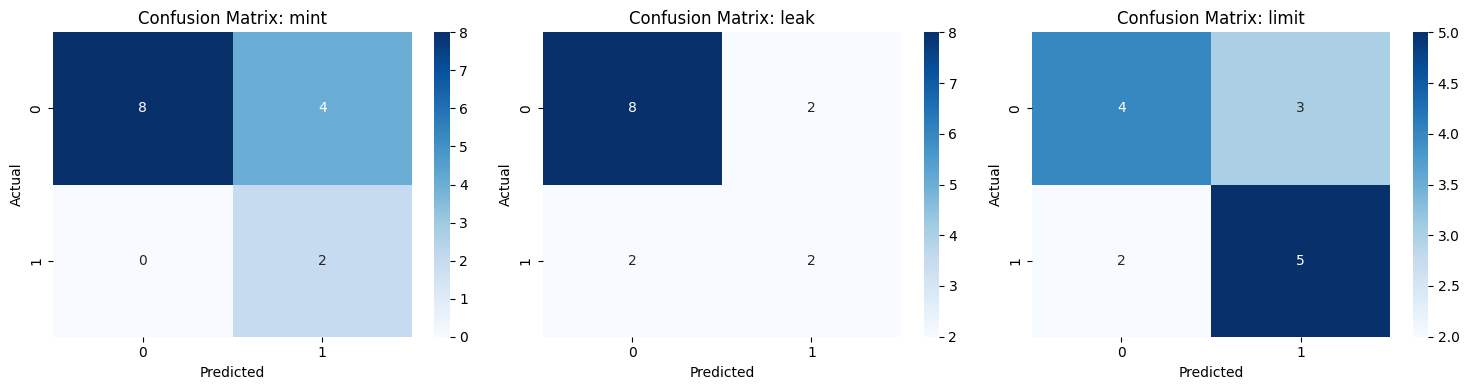

In [37]:
best_model = models[df_report['Model'][0]]
y_pred = best_model.predict(X_test)

display_multilabel_confusion_matrix(y_test, y_pred)

In [38]:
labels = y.columns.tolist()  # assuming y is a pandas DataFrame

for i, label in enumerate(labels):
    report_dict = classification_report(y_test[label], y_pred[:, i], output_dict=True)
    f1 = report_dict["macro avg"]["f1-score"]
    print(f"{label}, f1-score: {f1}")

mint, f1-score: 0.65
leak, f1-score: 0.65
limit, f1-score: 0.641025641025641


In [39]:
df_report = get_report_all_ml(grouping_X_train, grouping_y_train, grouping_X_test, grouping_y_test)
df_report

[LightGBM] [Info] Number of positive: 17, number of negative: 36
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 601
[LightGBM] [Info] Number of data points in the train set: 53, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.320755 -> initscore=-0.750306
[LightGBM] [Info] Start training from score -0.750306
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

,Model,Precision,Recall,F1-score
0,OneVsRestClassifier(KNeighborsClassifier()),0.515873,0.654762,0.515873
1,MultiOutputClassifier(KNeighborsClassifier()),0.515873,0.654762,0.515873
2,MultiOutputClassifier(GaussianNB()),0.422619,0.571429,0.462963
3,OneVsRestClassifier(GaussianNB()),0.422619,0.571429,0.462963
4,MultiOutputClassifier(MLPClassifier()),0.351852,0.571429,0.430556
5,MultiOutputClassifier(AdaBoostClassifier()),0.400000,0.523810,0.412698
6,OneVsRestClassifier(ExtraTreesClassifier()),0.400000,0.523810,0.412698
7,OneVsRestClassifier(AdaBoostClassifier()),0.400000,0.523810,0.412698
8,OneVsRestClassifier(RandomForestClassifier()),0.349206,0.571429,0.404762
9,MultiOutputClassifier(ExtraTreesClassifier()),0.355556,0.523810,0.395604


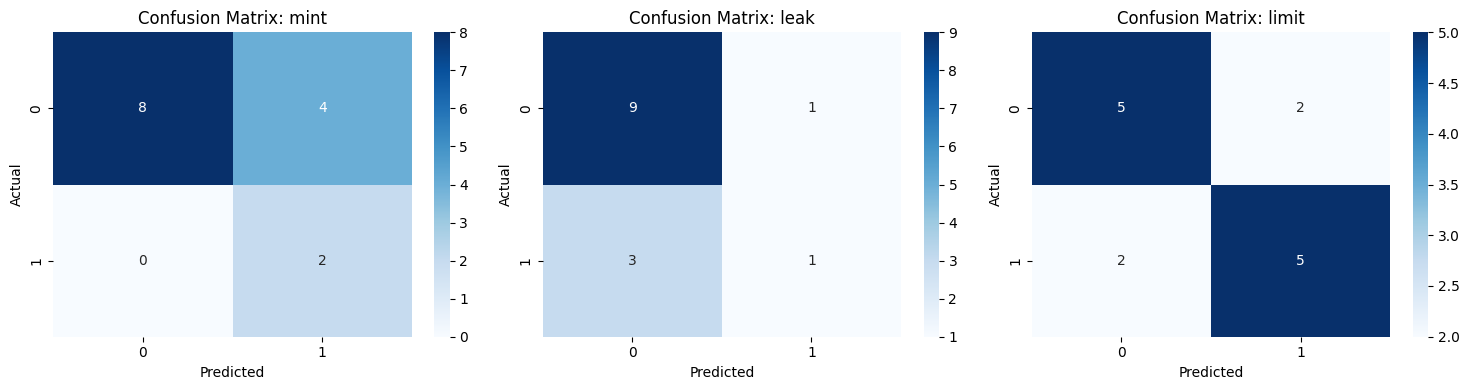

In [40]:
best_model = models[df_report['Model'][0]]
y_pred = best_model.predict(grouping_X_test)

display_multilabel_confusion_matrix(grouping_y_test, y_pred)

In [41]:
labels = y.columns.tolist()  # assuming y is a pandas DataFrame

for i, label in enumerate(labels):
    report_dict = classification_report(grouping_y_test[label], y_pred[:, i], output_dict=True)
    f1 = report_dict["macro avg"]["f1-score"]
    print(f"{label}, f1-score: {f1}")

mint, f1-score: 0.65
leak, f1-score: 0.5757575757575758
limit, f1-score: 0.7142857142857143


## MLP

### Build model

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import MeanSquaredError

2025-07-15 11:55:28.581213: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [43]:
def Model(input_dim, output_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(512, kernel_regularizer=regularizers.l1_l2(1e-6)),
        BatchNormalization(),
        LeakyReLU(0.01),
        Dropout(0.4),

        Dense(256, kernel_regularizer=regularizers.l1_l2(1e-6)),
        BatchNormalization(),
        LeakyReLU(0.01),
        Dropout(0.3),

        Dense(128, kernel_regularizer=regularizers.l1_l2(1e-6)),
        BatchNormalization(),
        LeakyReLU(0.01),
        Dropout(0.2),

        Dense(output_dim, activation='sigmoid')  # sigmoid for multi-label
    ])

    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=1e-6),
        metrics=['accuracy']
    )
    return model

In [44]:
model = Model(input_dim=X.shape[1], output_dim=y.shape[1])

In [45]:
grouping_model = Model(input_dim=grouping_X.shape[1], output_dim=y.shape[1])

### Train

In [46]:
model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=32,
                    callbacks=[
                                EarlyStopping(monitor='val_loss',
                                             patience=5,
                                             restore_best_weights=True),
                                ReduceLROnPlateau(
                                  monitor='val_loss',
                                  factor=0.5,
                                  patience=5,
                                  verbose=1)
                               ]
                    )

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 308ms/step - accuracy: 0.1999 - loss: 0.8046 - val_accuracy: 0.0000e+00 - val_loss: 3.6206 - learning_rate: 1.0000e-06
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.4102 - loss: 0.7983 - val_accuracy: 0.0000e+00 - val_loss: 2.3389 - learning_rate: 1.0000e-06
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.2684 - loss: 0.7896 - val_accuracy: 0.0000e+00 - val_loss: 1.9098 - learning_rate: 1.0000e-06
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.2054 - loss: 0.8247 - val_accuracy: 0.0000e+00 - val_loss: 1.6375 - learning_rate: 1.0000e-06
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.2262 - loss: 0.8045 - val_accuracy: 0.0000e+00 - val_loss: 1.4896 - learning_rate: 1.0000e-06
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.1632 - loss: 0.7969 - val_accuracy: 0.0000e+00 - val_loss: 1.3640 - learning_rate: 1.0000e-06
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step -

In [47]:
grouping_model.fit(grouping_X_train, grouping_y_train, validation_split=0.2, epochs=100, batch_size=32,
                    callbacks=[
                                EarlyStopping(monitor='val_loss',
                                             patience=5,
                                             restore_best_weights=True),
                                ReduceLROnPlateau(
                                  monitor='val_loss',
                                  factor=0.5,
                                  patience=5,
                                  verbose=1)
                               ]
                    )

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 294ms/step - accuracy: 0.2316 - loss: 0.8415 - val_accuracy: 0.0000e+00 - val_loss: 2.9855 - learning_rate: 1.0000e-06
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.2684 - loss: 0.7868 - val_accuracy: 0.0000e+00 - val_loss: 2.1243 - learning_rate: 1.0000e-06
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.2946 - loss: 0.8139 - val_accuracy: 0.0000e+00 - val_loss: 1.7892 - learning_rate: 1.0000e-06
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.2103 - loss: 0.8849 - val_accuracy: 0.0000e+00 - val_loss: 1.6118 - learning_rate: 1.0000e-06
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.2629 - loss: 0.8582 - val_accuracy: 0.0000e+00 - val_loss: 1.4787 - learning_rate: 1.0000e-06
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.3472 - loss: 0.9136 - val_accuracy: 0.0000e+00 - val_loss: 1.3716 - learning_rate: 1.0000e-06
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step -

### Predict

In [48]:
y_test_prob = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


In [49]:
def tune_thresholds(y_true, y_pred_prob, metric='f1'):
    y_true = np.asarray(y_true)          # Fix: convert to NumPy
    y_pred_prob = np.asarray(y_pred_prob)

    best_thresholds = []
    best_scores = []

    for i in range(y_true.shape[1]):
        label_true = y_true[:, i]
        label_probs = y_pred_prob[:, i]  # Fix here too

        thresholds = np.linspace(0.0, 1.0, 101)
        scores = []

        for t in thresholds:
            label_pred = (label_probs >= t).astype(int)
            if metric == 'f1':
                score = f1_score(label_true, label_pred, zero_division=0)
            scores.append(score)

        best_t = thresholds[np.argmax(scores)]
        best_score = np.max(scores)

        best_thresholds.append(best_t)
        best_scores.append(best_score)

        print(f"Label {i}: Best threshold = {best_t:.2f}, Best {metric} = {best_score:.4f}")

    return best_thresholds, best_scores


In [50]:
best_thresholds, _ = tune_thresholds(y_test, y_test_prob)

Label 0: Best threshold = 0.39, Best f1 = 0.4444
Label 1: Best threshold = 0.59, Best f1 = 0.7500
Label 2: Best threshold = 0.00, Best f1 = 0.6667


In [51]:
y_pred = (model.predict(X_test) >= best_thresholds).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


In [53]:
grouping_y_test_prob = grouping_model.predict(grouping_X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


In [54]:
grouping_best_thresholds, _ = tune_thresholds(grouping_y_test, grouping_y_test_prob)

Label 0: Best threshold = 0.65, Best f1 = 0.5000
Label 1: Best threshold = 0.63, Best f1 = 0.5000
Label 2: Best threshold = 0.50, Best f1 = 0.7500


In [55]:
grouping_y_pred = (grouping_model.predict(grouping_X_test) >= grouping_best_thresholds).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


### Report

In [56]:
print(classification_report(y_test, y_pred, target_names=y.columns))

              precision    recall  f1-score   support

        mint       0.29      1.00      0.44         2
        leak       0.75      0.75      0.75         4
       limit       0.50      1.00      0.67         7

   micro avg       0.48      0.92      0.63        13
   macro avg       0.51      0.92      0.62        13
weighted avg       0.54      0.92      0.66        13
 samples avg       0.51      0.57      0.53        13



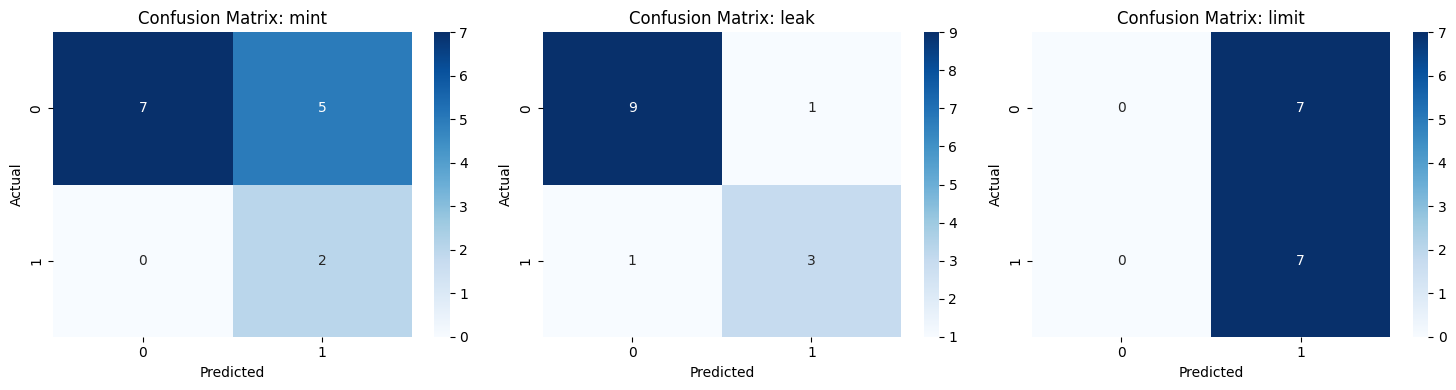

In [57]:
display_multilabel_confusion_matrix(y_test, y_pred)

In [58]:
print(classification_report(grouping_y_test, grouping_y_pred, target_names=y.columns))

              precision    recall  f1-score   support

        mint       0.50      0.50      0.50         2
        leak       0.50      0.50      0.50         4
       limit       0.67      0.86      0.75         7

   micro avg       0.60      0.69      0.64        13
   macro avg       0.56      0.62      0.58        13
weighted avg       0.59      0.69      0.63        13
 samples avg       0.48      0.43      0.44        13



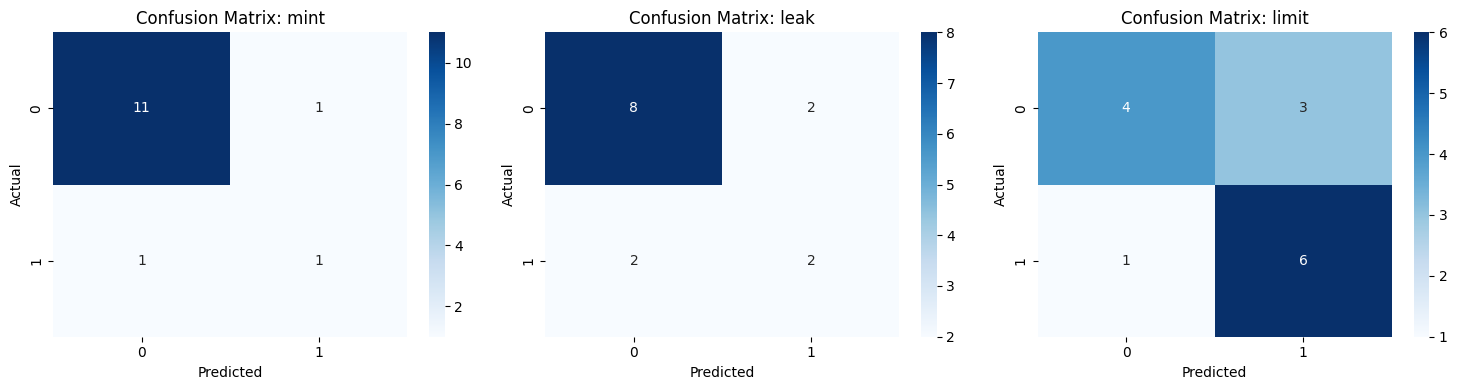

In [59]:
display_multilabel_confusion_matrix(grouping_y_test, grouping_y_pred)

## Autoencoder + MPL

In [60]:
def Autoencoder(input_dim=256):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(128),
        LeakyReLU(0.01),

        Dense(32),
        BatchNormalization(),
        LeakyReLU(0.01),

        Dense(128),
        BatchNormalization(),
        LeakyReLU(0.01),

        Dense(input_dim, activation='sigmoid')  # sigmoid for multi-label
    ])

    model.compile(optimizer=Adam(1e-6), loss=MeanSquaredError())
    return model


In [61]:
autoencoder = Autoencoder(input_dim=X.shape[1])
autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 212ms/step - loss: 8650.4248 - val_loss: 5996.2974
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 8620.5322 - val_loss: 5996.7388
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 9238.5244 - val_loss: 5996.8486
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 8505.7188 - val_loss: 5997.0605
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 8005.4731 - val_loss: 5997.2153
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 9312.7275 - val_loss: 5997.2793
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 8706.1387 - val_loss: 5997.3354
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 9078.4033 - val_loss: 5997.4204
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 8946.2119 - val_loss: 5997.5000
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 8395.2188 - val_loss: 5997.5659
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 9280.8096 - val_loss: 5997.5996
Epoch 12/50
2/2 ━

In [62]:
grouping_autoencoder = Autoencoder(input_dim=grouping_X.shape[1])
grouping_autoencoder.fit(grouping_X_train, grouping_X_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 218ms/step - loss: 33843.7578 - val_loss: 24727.3359
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 37558.7578 - val_loss: 24728.3945
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 36622.8906 - val_loss: 24729.4141
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 34144.8984 - val_loss: 24730.1562
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 36630.8125 - val_loss: 24730.7422
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 33990.2070 - val_loss: 24731.2695
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 35018.8164 - val_loss: 24731.7949
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 33847.3750 - val_loss: 24732.2441
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 35743.2109 - val_loss: 24732.6270
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 37609.1992 - val_loss: 24732.9121
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 36191.2656 - val_loss: 24733.2

In [63]:
X_train_encoded = autoencoder.predict(X_train)
X_test_encoded = autoencoder.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


In [65]:
grouping_X_train_encoded = grouping_autoencoder.predict(grouping_X_train)
grouping_X_test_encoded = grouping_autoencoder.predict(grouping_X_test)

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/stepWARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x140e0a5c0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


In [66]:
model = Model(input_dim=X_train_encoded.shape[1], output_dim=y.shape[1])

In [67]:
grouping_model = Model(input_dim=grouping_X_train_encoded.shape[1], output_dim=grouping_y.shape[1])

In [68]:
model.fit(X_train_encoded, y_train, validation_split=0.2, epochs=100, batch_size=32,
                    callbacks=[
                                EarlyStopping(monitor='val_loss',
                                             patience=5,
                                             restore_best_weights=True),
                                ReduceLROnPlateau(
                                  monitor='val_loss',
                                  factor=0.5,
                                  patience=5,
                                  verbose=1)
                               ]
                    )

Epoch 1/100


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 312ms/step - accuracy: 0.5685 - loss: 0.7812 - val_accuracy: 0.8182 - val_loss: 0.7093 - learning_rate: 1.0000e-06
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5630 - loss: 0.7838 - val_accuracy: 0.8182 - val_loss: 0.7086 - learning_rate: 1.0000e-06
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.5159 - loss: 0.8083 - val_accuracy: 0.8182 - val_loss: 0.7073 - learning_rate: 1.0000e-06
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.5843 - loss: 0.7662 - val_accuracy: 0.8182 - val_loss: 0.7073 - learning_rate: 1.0000e-06
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.5789 - loss: 0.8230 - val_accuracy: 0.8182 - val_loss: 0.7071 - learning_rate: 1.0000e-06
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.5263 - loss: 0.8333 - val_accuracy: 0.8182 - val_loss: 0.7056 - learning_rate: 1.0000e-06
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.5526 - loss: 0.8329 - v

In [69]:
grouping_model.fit(grouping_X_train_encoded, grouping_y_train, validation_split=0.2, epochs=100, batch_size=32,
                    callbacks=[
                                EarlyStopping(monitor='val_loss',
                                             patience=5,
                                             restore_best_weights=True),
                                ReduceLROnPlateau(
                                  monitor='val_loss',
                                  factor=0.5,
                                  patience=5,
                                  verbose=1)
                               ]
                    )

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 550ms/step - accuracy: 0.4683 - loss: 0.9042 - val_accuracy: 0.8182 - val_loss: 0.7138 - learning_rate: 1.0000e-06
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.6314 - loss: 0.9992 - val_accuracy: 0.8182 - val_loss: 0.7159 - learning_rate: 1.0000e-06
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.5208 - loss: 0.9027 - val_accuracy: 0.8182 - val_loss: 0.7180 - learning_rate: 1.0000e-06
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.5526 - loss: 0.9630 - val_accuracy: 0.8182 - val_loss: 0.7206 - learning_rate: 1.0000e-06
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.5317 - loss: 0.9743 - val_accuracy: 0.8182 - val_loss: 0.7224 - learning_rate: 1.0000e-06
Epoch 6/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4688 - loss: 0.9281
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999987376214e-07.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.5213 - loss: 0.90

In [70]:
y_pred_prob = model.predict(X_test_encoded)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


In [75]:
grouping_y_pred_prob = grouping_model.predict(grouping_X_test_encoded)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


In [76]:
best_thresholds, _ = tune_thresholds(y_test, y_test_prob)

Label 0: Best threshold = 0.39, Best f1 = 0.4444
Label 1: Best threshold = 0.59, Best f1 = 0.7500
Label 2: Best threshold = 0.00, Best f1 = 0.6667


In [77]:
grouping_best_thresholds, _ = tune_thresholds(grouping_y_test, grouping_y_test_prob)

Label 0: Best threshold = 0.65, Best f1 = 0.5000
Label 1: Best threshold = 0.63, Best f1 = 0.5000
Label 2: Best threshold = 0.50, Best f1 = 0.7500


In [78]:
y_pred = (model.predict(X_test) >= best_thresholds).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


In [79]:
grouping_y_pred = (grouping_model.predict(grouping_X_test) >= grouping_best_thresholds).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


### Report

In [80]:
print(classification_report(y_test, y_pred, target_names=y.columns))

              precision    recall  f1-score   support

        mint       0.17      1.00      0.29         2
        leak       0.00      0.00      0.00         4
       limit       0.50      1.00      0.67         7

   micro avg       0.35      0.69      0.46        13
   macro avg       0.22      0.67      0.32        13
weighted avg       0.29      0.69      0.40        13
 samples avg       0.36      0.43      0.37        13



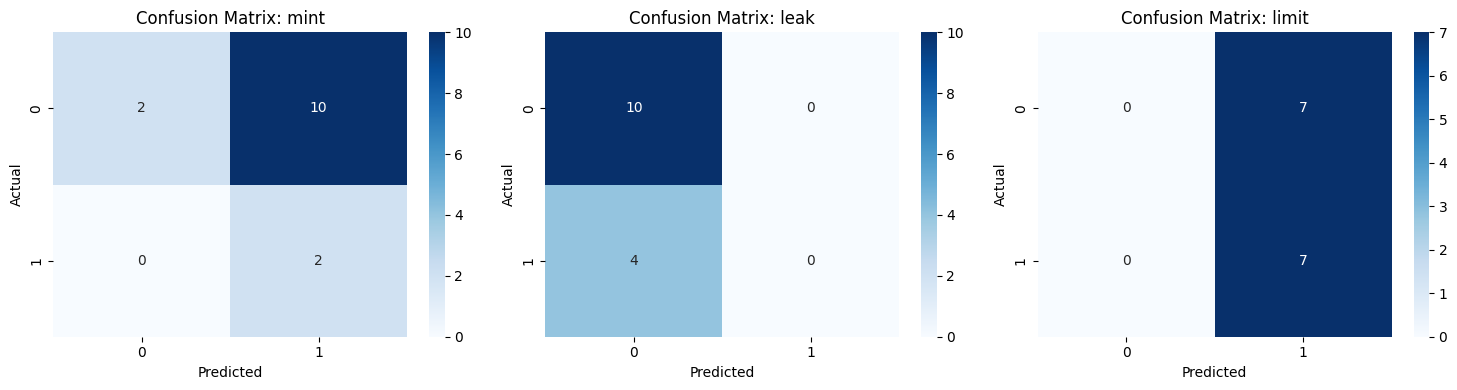

In [81]:
display_multilabel_confusion_matrix(y_test, y_pred)

In [82]:
print(classification_report(grouping_y_test, grouping_y_pred, target_names=y.columns))

              precision    recall  f1-score   support

        mint       0.14      1.00      0.25         2
        leak       0.29      1.00      0.44         4
       limit       0.50      1.00      0.67         7

   micro avg       0.31      1.00      0.47        13
   macro avg       0.31      1.00      0.45        13
weighted avg       0.38      1.00      0.53        13
 samples avg       0.31      0.64      0.41        13



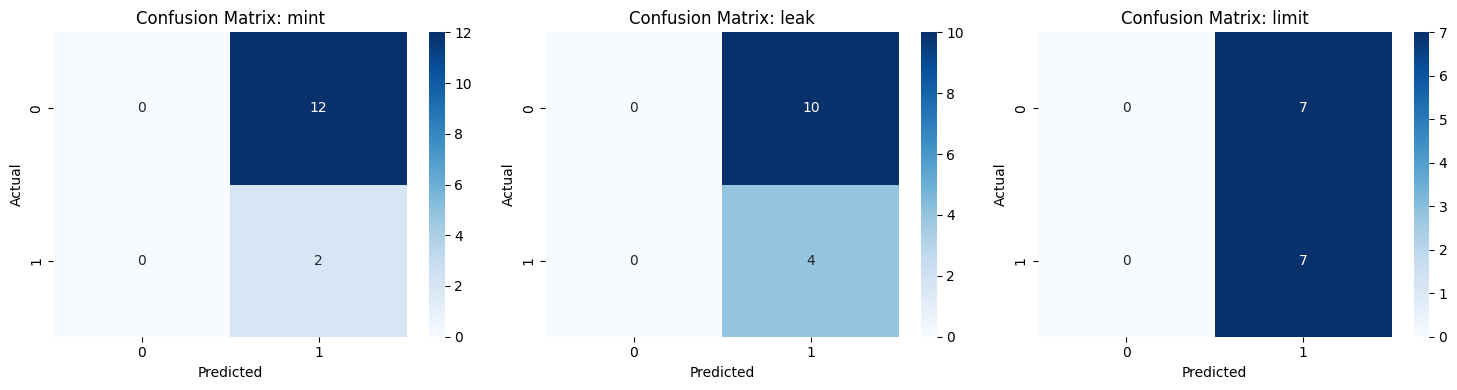

In [83]:
display_multilabel_confusion_matrix(grouping_y_test, grouping_y_pred)